[Title - Edit?]
# Pop-Up Course: Better metal forming by linking experiment, modeling, and process control  
#### July 29-30, 2019

## Monte Carlo Grain Growth Simulation

[Introduction] + theory 

[Code Intro/Algo] explaination

In [1]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import random

# Inline Plots

%matplotlib inline

In [2]:
""" 
Function to calculate distance between 2 points
Needs the points in form of numpy array, returns the scalar distance
"""

def EucDist2D(x1,x2):
    dist=np.linalg.norm(x1-x2)
    return dist

In [16]:
nSeeds= 10  # Seeds to start tesselation
N = 100 # Square Domain size
N2D=N**N
x=np.linspace(0,N,N)
y=np.linspace(0,N,N)
seedCoord=np.zeros([nSeeds,2])
for i in range(0, nSeeds):
    seedCoord[i,0] = random.randint(0, N)
    seedCoord[i,1] = random.randint(0, N)

In [17]:
dist=np.zeros([nSeeds,1])
grainID=np.zeros([N,N])
for i in range(0,N):
    for j in range(0,N):
        minDist=float("inf")
        for k in range(0,nSeeds):
            dist[k]=EucDist2D(seedCoord[k],np.array([x[i],y[j]]))
        grainID[i,j]=np.argmin(dist)
                
    

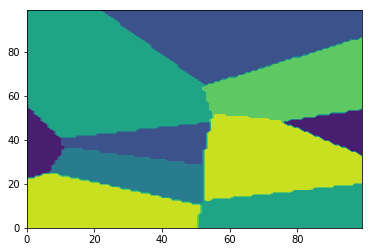

In [18]:
plt.contourf(grainID)